## Gathering Dependencies

_Importing Required Libraries_

In [1]:
pip install hampel

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
from numpy import array

## Pretraining

_Henon Heiles Intermittency_

The `henon_heiles_intermittency.dat` feeds the model with the dynamics of the Henon Heiles Equations.

In [3]:
data = np.genfromtxt('datasets/henon_heiles_intermittency.dat')
training_set = pd.DataFrame(data).reset_index(drop=True)
training_set = training_set.iloc[:,1]

## Computing the Gradients

_Calculating the value of_ $\frac{dx}{dt}$, _and_ $\frac{d^2x}{dt^2}$

In [4]:
t_diff = 1 # Weekly Data
print(training_set.max())
gradient_t = (training_set.diff()/t_diff).iloc[1:]
print(gradient_t)
gradient_tt = (gradient_t.diff()/t_diff).iloc[1:]
print(gradient_tt)

0.099
1        -0.000989
2        -0.000979
3        -0.000968
4        -0.000958
5        -0.000947
            ...   
139867    0.000000
139868    0.000000
139869    0.000000
139870    0.000000
139871    0.000000
Name: 1, Length: 139871, dtype: float64
2         0.000011
3         0.000010
4         0.000010
5         0.000010
6         0.000010
            ...   
139867    0.000000
139868    0.000000
139869    0.000000
139870    0.000000
139871    0.000000
Name: 1, Length: 139870, dtype: float64


## Loading Datasets

_TURKEY EARTHQUAKE_

In [5]:
data = pd.read_csv("datasets/eq.csv")
training_set = data.iloc[:, 4]
print(training_set)

0       4.4
1       5.2
2       4.8
3       4.4
4       5.7
       ... 
6569    4.5
6570    4.0
6571    4.4
6572    4.1
6573    4.0
Name: Magnitude, Length: 6574, dtype: float64


In [6]:
training_set = training_set.reset_index(drop=True)
gradient_t = gradient_t.reset_index(drop=True)
gradient_tt = gradient_tt.reset_index(drop=True)
print(gradient_t)
print(gradient_tt)

0        -0.000989
1        -0.000979
2        -0.000968
3        -0.000958
4        -0.000947
            ...   
139866    0.000000
139867    0.000000
139868    0.000000
139869    0.000000
139870    0.000000
Name: 1, Length: 139871, dtype: float64
0         0.000011
1         0.000010
2         0.000010
3         0.000010
4         0.000010
            ...   
139865    0.000000
139866    0.000000
139867    0.000000
139868    0.000000
139869    0.000000
Name: 1, Length: 139870, dtype: float64


In [7]:
print(gradient_t.shape)
print(training_set.shape[:-1])
df = pd.concat((training_set[:-1], gradient_t), axis=1)
gradient_tt.columns = ["grad_tt"]
df = pd.concat((df[:-1], gradient_tt), axis=1)
df.columns = ['y_t', 'grad_t', 'grad_tt']

(139871,)
()


## Plot of the External Forcing from Chaotic Differential Equation (_Van der Pol Oscillator_)

<AxesSubplot:>

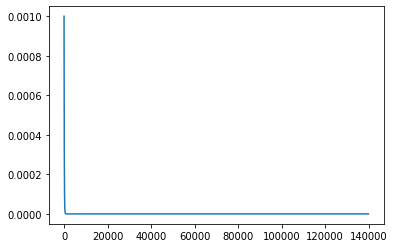

In [8]:
L = df.iloc[:, 2] - df.iloc[:, 1]
L.plot()

## Preprocessing the data into supervised learning

In [9]:
def Supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
       agg.dropna(inplace=True)
    return agg    

In [10]:
dat = Supervised(df.values, n_in = 10, n_out = 52)
dat.columns

Index(['var1(t-10)', 'var2(t-10)', 'var3(t-10)', 'var1(t-9)', 'var2(t-9)',
       'var3(t-9)', 'var1(t-8)', 'var2(t-8)', 'var3(t-8)', 'var1(t-7)',
       ...
       'var3(t+48)', 'var1(t+49)', 'var2(t+49)', 'var3(t+49)', 'var1(t+50)',
       'var2(t+50)', 'var3(t+50)', 'var1(t+51)', 'var2(t+51)', 'var3(t+51)'],
      dtype='object', length=186)

In [11]:
data = Supervised(df.values, n_in = 10, n_out = 52)
data.drop(['var2(t-10)', 'var3(t-10)', 'var2(t-9)', 'var3(t-9)', 'var2(t-8)',
       'var3(t-8)', 'var2(t-7)', 'var3(t-7)', 'var2(t-6)', 'var3(t-6)',
       'var2(t-5)', 'var3(t-5)', 'var2(t-4)', 'var3(t-4)', 'var2(t-2)',
       'var3(t-2)', 'var2(t-1)', 'var3(t-1)','var2(t-3)', 'var3(t-3)'], axis = 1, inplace = True)#,18,19
print(data.head())
print(data.columns)

    var1(t-10)  var1(t-9)  var1(t-8)  var1(t-7)  var1(t-6)  var1(t-5)  \
10         4.4        5.2        4.8        4.4        5.7        4.3   
11         5.2        4.8        4.4        5.7        4.3        4.0   
12         4.8        4.4        5.7        4.3        4.0        4.8   
13         4.4        5.7        4.3        4.0        4.8        5.2   
14         5.7        4.3        4.0        4.8        5.2        5.1   

    var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  ...  var3(t+48)  var1(t+49)  \
10        4.0        4.8        5.2        5.1  ...    0.000005         4.4   
11        4.8        5.2        5.1        4.7  ...    0.000005         5.9   
12        5.2        5.1        4.7        4.6  ...    0.000005         4.7   
13        5.1        4.7        4.6        4.4  ...    0.000005         4.4   
14        4.7        4.6        4.4        4.7  ...    0.000005         5.0   

    var2(t+49)  var3(t+49)  var1(t+50)  var2(t+50)  var3(t+50)  var1(t+51)  \
10   -0.

## Train and Test Split

In [12]:
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train_1 = np.array(data[0:train_size])
test_1 = np.array(data[train_size:len(data)])
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train_1)
test = scaler.transform(test_1)
trainY = train[:,-9:]
trainX = train[:,:-9]
testY = test[:,-9:]
testX = test[:,:-9]
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(5209, 1, 157) (5209, 9) (1303, 1, 157) (1303, 9)


## Defining the Physical Loss

In [13]:
a = tf.Variable(0.1, name="alpha", trainable=True, dtype=tf.float32)
b = tf.Variable(0.05, name="beta", trainable=True, dtype=tf.float32)
c = tf.Variable(1.1, name="gamma", trainable=True, dtype=tf.float32)
d = tf.Variable(0.1, name="delta", trainable=True, dtype=tf.float32)


def phys(y_pred, y_true):
    return mean_absolute_error((y_true[:, 2] - y_true[:, 1]), (y_pred[:, 2] - y_pred[:, 1]))

def phys2(y_pred, y_real):
    pred = y_pred[2:]-2*y_pred[1:-1]-y_pred[:-2] - (y_pred[1:-1]-y_pred[:-2])
    real = y_real[2:]-2*y_real[1:-1]-y_real[:-2] - (y_real[1:-1]-y_pred[:-2])
    return(mean_absolute_error(pred, real))

## Model (Without Monte Carlo Dropout)

In [14]:
def loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true[:, 0] - y_pred[:, 0])
    squared_difference2 = tf.square(y_true[:, 2]-y_pred[:, 2])
    squared_difference1 = tf.square(y_true[:, 1]-y_pred[:, 1])
    squared_difference3 = tf.square((y_pred[:, 2] - y_pred[:, 1]))
    return tf.reduce_mean(squared_difference, axis=-1) + 0.2*tf.reduce_mean(squared_difference3, axis=-1)

model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(9))
model.compile(loss=loss_fn, optimizer='adam')
history = model.fit(trainX[:int(0.8*trainX.shape[0])], trainY[:int(0.8*trainX.shape[0])], epochs=500, batch_size=64, validation_data=(trainX[int(0.8*trainX.shape[0]):trainX.shape[0]], trainY[int(0.8*trainX.shape[0]):trainX.shape[0]]), shuffle=False)

Epoch 1/500
66/66 [==============================] - 2s 9ms/step - loss: 0.0139 - val_loss: 0.0107
Epoch 2/500
66/66 [==============================] - 0s 3ms/step - loss: 0.0160 - val_loss: 0.0114
Epoch 3/500
66/66 [==============================] - 0s 3ms/step - loss: 0.0175 - val_loss: 0.0110
Epoch 4/500
66/66 [==============================] - 0s 3ms/step - loss: 0.0203 - val_loss: 0.0106
Epoch 5/500
66/66 [==============================] - 0s 3ms/step - loss: 0.0173 - val_loss: 0.0106
Epoch 6/500
66/66 [==============================] - 0s 3ms/step - loss: 0.0163 - val_loss: 0.0106
Epoch 7/500
66/66 [==============================] - 0s 3ms/step - loss: 0.0152 - val_loss: 0.0106
Epoch 8/500
66/66 [==============================] - 0s 3ms/step - loss: 0.0144 - val_loss: 0.0106
Epoch 9/500
66/66 [==============================] - 0s 3ms/step - loss: 0.0138 - val_loss: 0.0106
Epoch 10/500
66/66 [==============================] - 0s 3ms/step - loss: 0.0134 - val_loss: 0.0107
Epoch 11/

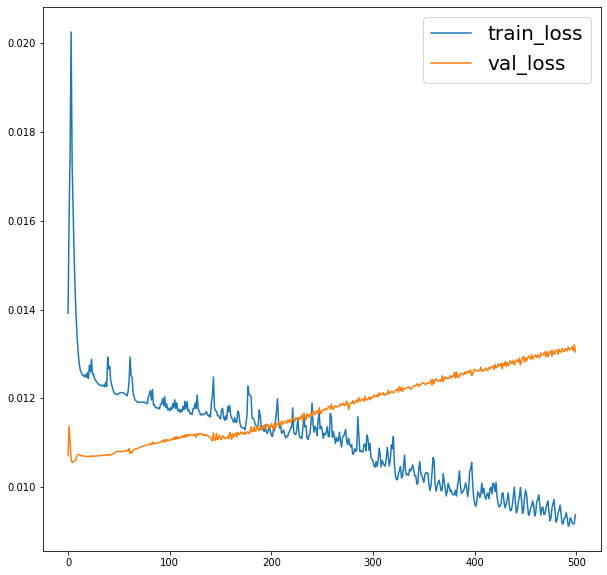

In [15]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(fontsize=20)
plt.show()

## Metrics (Without Monte Carlo Dropout)

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
textX_without_mc = testX
textY_without_mc = testY
yhat_without_mc = model.predict(textX_without_mc)
print(yhat_without_mc.shape)
textX_without_mc = textX_without_mc.reshape((textX_without_mc.shape[0], textX_without_mc.shape[2]))
print(textX_without_mc.shape)
inv_yhat_without_mc = np.concatenate((textX_without_mc, yhat_without_mc), axis=1)
inv_yhat_without_mc = scaler.inverse_transform(inv_yhat_without_mc)
inv_yhat1_without_mc = inv_yhat_without_mc[:, -3:]
inv_yhat_without_mc = inv_yhat_without_mc[:, -3]
inv_y_without_mc = np.concatenate((textX_without_mc, textY_without_mc), axis=1)
inv_y_without_mc = scaler.inverse_transform(inv_y_without_mc)
inv_y1_without_mc = inv_y_without_mc[:, -3:]
inv_y_without_mc = inv_y_without_mc[:, -3]
rmse_without_mc = np.sqrt(mean_squared_error(inv_y_without_mc, inv_yhat_without_mc))
mae_without_mc = mean_absolute_error(inv_y_without_mc, inv_yhat_without_mc)
print('Test RMSE: %.3f' % rmse_without_mc)
print('Test MAE: %.3f' % mae_without_mc)

41/41 [==============================] - 1s 2ms/step
(1303, 9)
(1303, 157)
Test RMSE: 0.766
Test MAE: 0.676


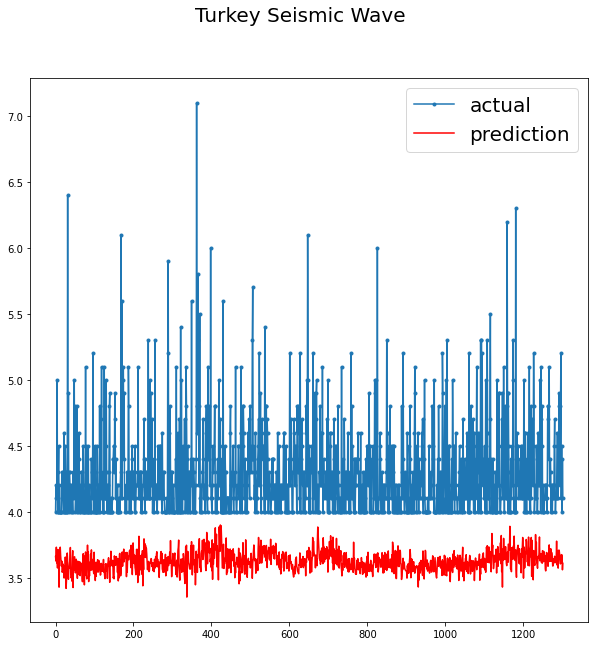

In [17]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(inv_y_without_mc, marker='.', label="actual")
plt.plot(inv_yhat_without_mc, 'r', label="prediction")
plt.suptitle('Turkey Seismic Wave', fontsize=20)
plt.legend(fontsize=20)
plt.show()

## Model (With Monte Carlo Dropout)

In [18]:
class MCDropout(Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [19]:
def loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true[:, 0] - y_pred[:, 0])
    squared_difference2 = tf.square(y_true[:, 2]-y_pred[:, 2])
    squared_difference1 = tf.square(y_true[:, 1]-y_pred[:, 1])
    squared_difference3 = tf.square((y_pred[:, 2] - y_pred[:, 1]))
    return tf.reduce_mean(squared_difference, axis=-1) + 0.2*tf.reduce_mean(squared_difference3, axis=-1)

model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(9))
model.add(MCDropout(0.4))
model.compile(loss=loss_fn, optimizer='adam')
history = model.fit(trainX[:int(0.8*trainX.shape[0])], trainY[:int(0.8*trainX.shape[0])], epochs=500, batch_size=64, validation_data=(trainX[int(0.8*trainX.shape[0]):trainX.shape[0]], trainY[int(0.8*trainX.shape[0]):trainX.shape[0]]), shuffle=False)

Epoch 1/500
66/66 [==============================] - 3s 14ms/step - loss: 0.0258 - val_loss: 0.0136
Epoch 2/500
66/66 [==============================] - 0s 4ms/step - loss: 0.0278 - val_loss: 0.0131
Epoch 3/500
66/66 [==============================] - 0s 5ms/step - loss: 0.0252 - val_loss: 0.0138
Epoch 4/500
66/66 [==============================] - 0s 7ms/step - loss: 0.0321 - val_loss: 0.0133
Epoch 5/500
66/66 [==============================] - 0s 5ms/step - loss: 0.0280 - val_loss: 0.0125
Epoch 6/500
66/66 [==============================] - 0s 4ms/step - loss: 0.0260 - val_loss: 0.0124
Epoch 7/500
66/66 [==============================] - 0s 4ms/step - loss: 0.0245 - val_loss: 0.0128
Epoch 8/500
66/66 [==============================] - 0s 4ms/step - loss: 0.0244 - val_loss: 0.0126
Epoch 9/500
66/66 [==============================] - 0s 4ms/step - loss: 0.0238 - val_loss: 0.0126
Epoch 10/500
66/66 [==============================] - 0s 4ms/step - loss: 0.0234 - val_loss: 0.0131
Epoch 11

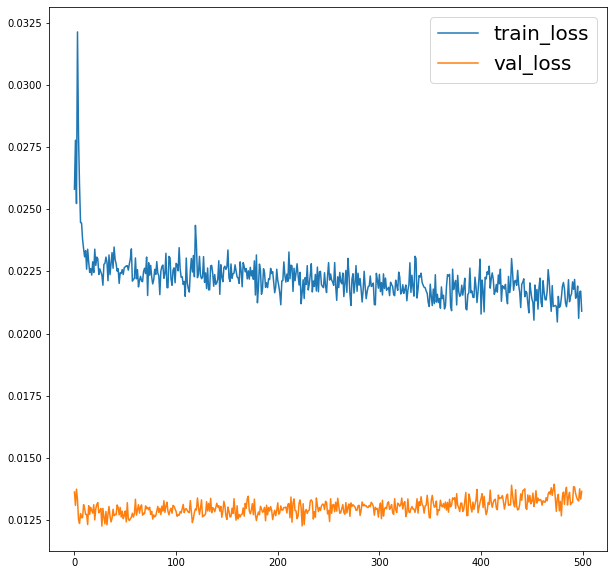

In [20]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(fontsize=20)
plt.show()

## Metrics (With Monte Carlo Dropout)

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
textX_with_mc = testX
textY_with_mc = testY
yhat_with_mc = model.predict(textX_with_mc)
print(yhat_with_mc.shape)
textX_with_mc = testX.reshape((textX_with_mc.shape[0], textX_with_mc.shape[2]))
print(textX_with_mc.shape)
inv_yhat_with_mc = np.concatenate((textX_with_mc, yhat_with_mc), axis=1)
inv_yhat_with_mc = scaler.inverse_transform(inv_yhat_with_mc)
inv_yhat1_with_mc = inv_yhat_with_mc[:, -3:]
inv_yhat_with_mc = inv_yhat_with_mc[:, -3]
inv_y_with_mc = np.concatenate((textX_with_mc, textY_with_mc), axis=1)
inv_y_with_mc = scaler.inverse_transform(inv_y_with_mc)
inv_y1_with_mc = inv_y_with_mc[:, -3:]
inv_y_with_mc = inv_y_with_mc[:, -3]
rmse_with_mc = np.sqrt(mean_squared_error(inv_y_with_mc, inv_yhat_with_mc))
mae_with_mc = mean_absolute_error(inv_y_with_mc, inv_yhat_with_mc)
print('Test RMSE: %.3f' % rmse_with_mc)
print('Test MAE: %.3f' % mae_with_mc)

41/41 [==============================] - 1s 2ms/step
(1303, 9)
(1303, 157)
Test RMSE: 0.462
Test MAE: 0.301


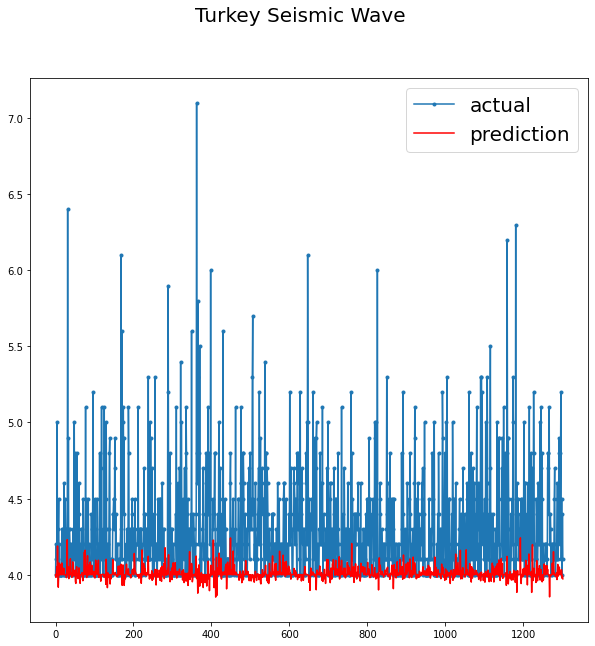

In [22]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(inv_y_with_mc, marker='.', label="actual")
plt.plot(inv_yhat_with_mc, 'r', label="prediction")
plt.suptitle('Turkey Seismic Wave', fontsize=20)
plt.legend(fontsize=20)
plt.show()